In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### 数据读取与理解

In [2]:
df_data_emails = pd.read_csv('./data/Emails.csv', usecols=[0,3,4,5])
df_data_emails.columns = ['email_id', 'receiver_s', 'sender', 'sender_id']

In [3]:
df_data_emails.head()

,email_id,receiver_s,sender,sender_id
0,1,H,"Sullivan, Jacob J",87.0
1,2,H,NaN,NaN
2,3,;H,"Mills, Cheryl D",32.0
3,4,H,"Mills, Cheryl D",32.0
4,5,"Abedin, Huma",H,80.0


In [4]:
df_data_emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7945 entries, 0 to 7944
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   email_id    7945 non-null   int64  
 1   receiver_s  7690 non-null   object 
 2   sender      7788 non-null   object 
 3   sender_id   7788 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 248.4+ KB


In [5]:
df_data_Aliases = pd.read_csv('./data/Aliases.csv',usecols=[1,2])
df_data_Aliases.columns = ['alias', 'person_id']

In [6]:
df_data_Aliases.head()

,alias,person_id
0,111th congress,1
1,agna usemb kabul afghanistan,2
2,ap,3
3,asuncion,4
4,alec,5


In [7]:
df_data_Aliases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   alias      850 non-null    object
 1   person_id  850 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.4+ KB


In [8]:
df_data_email_rec = pd.read_csv('./data/EmailReceivers.csv', usecols=[1,2])
df_data_email_rec.columns = ['email_id', 'receiver_id']

In [9]:
df_data_email_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9306 entries, 0 to 9305
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   email_id     9306 non-null   int64
 1   receiver_id  9306 non-null   int64
dtypes: int64(2)
memory usage: 145.5 KB


In [10]:
df_data_email_rec.head()

,email_id,receiver_id
0,1,80
1,2,80
2,3,228
3,3,80
4,4,80


### 数据清洗与整理
* 目标：得到以下一个表格 df_features

|email_id |sender |sender_id| receiver|receiver_id|
|--|--|--|--|--|
|99|name|99|name|99|

In [11]:
# 创建人物id到名字的关联字典
person_id_to_alias = {}
for person_id, grouped_person_id in df_data_Aliases.groupby('person_id'):
    person_id_to_alias[person_id] = grouped_person_id['alias'].tolist()[0].split('@')[0]
person_id_to_alias[np.nan] = np.nan

In [12]:
# 创建email_id到sender_id字典
email_id_to_sender_id = {}
for email_id, sender_id in zip(df_data_emails['email_id'], df_data_emails['sender_id']):
    email_id_to_sender_id[email_id] = sender_id

In [13]:
# 创建df_features
df_features = pd.DataFrame(
    data=np.full(shape=(len(df_data_email_rec), 5), fill_value=np.nan),
    columns=['email_id', 'sender', 'sender_id', 'receiver', 'receiver_id']
)

In [14]:
# 创建数据
df_features['email_id'] = df_data_email_rec['email_id'].values
df_features['receiver_id'] = df_data_email_rec['receiver_id'].values
df_features['sender_id'] = df_data_email_rec['email_id'].apply(lambda x:email_id_to_sender_id[x])

In [15]:
df_features['sender'] = df_features['sender_id'].apply(lambda x:person_id_to_alias[x] if x in person_id_to_alias else np.nan)
df_features['receiver'] = df_features['receiver_id'].apply(lambda x:person_id_to_alias[x] if x in person_id_to_alias else np.nan)

In [16]:
df_features = df_features.dropna()
df_features['sender_id'] = df_features['sender_id'].astype(int)

In [17]:
df_features.head()

,email_id,sender,sender_id,receiver,receiver_id
0,1,sullivan jj,87,hillary clinton,80
2,3,c:mills cheryl,32,b6,228
3,3,c:mills cheryl,32,hillary clinton,80
4,4,c:mills cheryl,32,hillary clinton,80
5,5,hillary clinton,80,abedin huma,81


In [18]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9273 entries, 0 to 9305
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   email_id     9273 non-null   int64 
 1   sender       9273 non-null   object
 2   sender_id    9273 non-null   int64 
 3   receiver     9273 non-null   object
 4   receiver_id  9273 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 434.7+ KB


### 创建图

In [19]:
DG = nx.DiGraph()

In [20]:
DG_data_list = []
for sender, group_sender in df_features.groupby('sender'):
    for receiver, group_receiver in group_sender.groupby('receiver'):
        DG_data_list.append((sender, receiver, len(group_receiver)))
DG.add_weighted_edges_from(DG_data_list)

### 计算PageRank

In [21]:
pagerank_list = nx.pagerank(DG)

# 提取pr值大于pagerank_threshold的节点
extract_DG = DG.copy()
pagerank_threshold = 0.004
for node in pagerank_list:
    if pagerank_list[node] <= pagerank_threshold:
        extract_DG.remove_node(node)

### 绘制网络图

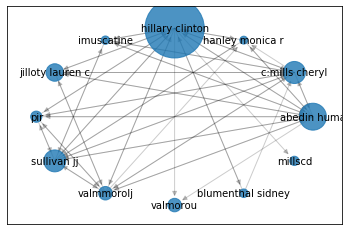

In [22]:
position = nx.circular_layout(extract_DG)
nx.draw_networkx_nodes(extract_DG, 
                       position, 
                       node_size=[pagerank_list[x[0]]*15000 for x in extract_DG.nodes.data()],
                       alpha = 0.8
)
nx.draw_networkx_edges(extract_DG, 
                       position, 
                       edge_size=[np.sqrt(x[2]['weight']) for x in extract_DG.edges.data()],
                       alpha = 0.2
)
nx.draw_networkx_labels(extract_DG, 
                        position, 
                        font_size=10
)
plt.show()